<a href="https://colab.research.google.com/github/LuFernandez/PASA/blob/master/2roma_mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
%cd content
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2.%20Laboratorio%20de%20filtrado%20óptimo/samples/sofunny.wav"
!wget "https://raw.githubusercontent.com/LuFernandez/PASA/master/TP2.%20Laboratorio%20de%20filtrado%20óptimo/records/grab-sofunny.wav"

!pip install -U pip setuptools
!git clone https://github.com/tritemio/pycorrelate.git
%cd content
%cd pycorrelate
!ls
!python setup.py install
clear_output()

import warnings
warnings.filterwarnings("ignore")
from scipy.io.wavfile import read
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import wave, struct, math, random
from IPython.display import Audio
from scipy import signal as sgn
from scipy.linalg import toeplitz
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import ccf
from pycorrelate import ucorrelate


In [3]:
!pip install soundfile
import soundfile as sf
def fast_plot(data):
    plt.plot(range(len(data)),data)
def normalize(datos):
    return np.interp(datos, (datos.min(), datos.max()), (-1, +1)) #normalizamos
def get_mono_array(stereo_file_name):
    file = read(stereo_file_name)
    fs = file[0]
    datos = np.array(file[1],dtype=float) 
    if len(np.shape(datos))>1: #si tiene dos canales
        ch0 = datos[:, 0]
        ch1 = datos[:, 1]
        datos = (ch0 + ch1)/2  # o lo hacemos mono
    return fs, datos


In [0]:
# Obtenemos los datos de sweep logaritmico
clear_output()

#file_name = "/content/grab_sweep_rapido.wav"
file_name = "/content/grab-sofunny.wav"  
fs, grab_audio = get_mono_array(file_name)
grab_audio /= np.max(np.abs(grab_audio),axis=0)
grab_audio /= np.max(np.abs(grab_audio),axis=0)
grab_audio = grab_audio - np.mean(grab_audio)
# file_name = "/content/sweep_rapido.wav"
file_name = "/content/sofunny.wav"
fs, audio = get_mono_array(file_name)

audio /= np.max(np.abs(audio),axis=0)
audio = audio-np.mean(audio)

  # """file_name = "/content/sin_lin_sweep_5s.wav"
  # audio, fs = sf.read(file_name)
  # file_name = "/content/RTA lin sweep_06.wav"
  # grab_audio, fs2 = sf.read(file_name)"""
u=audio
d=grab_audio

In [0]:
diff=len(d)-len(u)
evLen=7.977
u = u[int(0):int((evLen)*fs)]
d = d[int((0.336)*fs):int((0.336+evLen)*fs)]

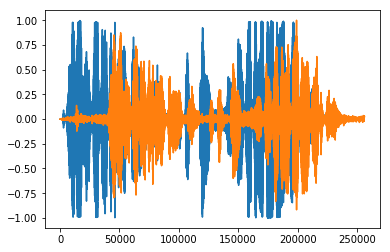

235436
256256


In [6]:
plt.plot(u)
plt.plot(d)
plt.show()
print(len(u))
print(len(d))
#plt.plot(audio[142000:len(audio)])
#plt.plot(grab_audio[142000:len(audio)])
#grab_audio=grab_audio[142000:a]
#audio=audio[142000:a]

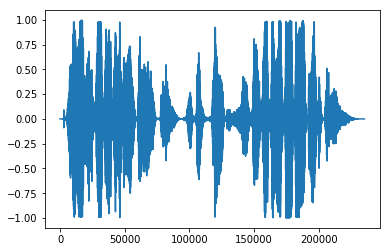

In [7]:
plt.plot(u)

In [8]:
# Esta es la grabación
Audio(d,rate=fs)

In [9]:
# Este es el audio original
Audio(u,rate=fs)

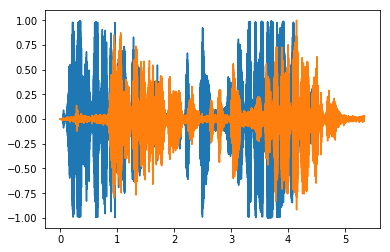

In [10]:
t=np.linspace(0,len(d)/fs,len(d))
t1=np.linspace(0,len(u)/fs,len(u))
plt.plot(t1,u)
plt.plot(t,d)

In [0]:
def adjustSignals(fs,u,d,deltaT):
    ##Agrego ceros si alguna señal tiene diferente tamaño
    diff = len(u) - len(d)
    if(diff > 0):
        d = np.concatenate((d,[0 for _ in range(diff)]))
    elif(diff < 0):
        u = np.concatenate((u,[0 for _ in range(-diff)]))
    
    ##Agrego un segundo de ceros al principio y al final
    uZ = np.array([0 for i in range(0,1*fs)])
    uZ = np.concatenate((uZ,u))
    uZ = np.concatenate((uZ,[0 for i in range(0,1*fs)]))

    dZ = np.array([0 for i in range(0,1*fs)])
    dZ = np.concatenate((dZ,d))
    dZ = np.concatenate((dZ,[0 for i in range(0,1*fs)]))
    return uZ,dZ
uZ, dZ =adjustSignals(fs,u,d,1)

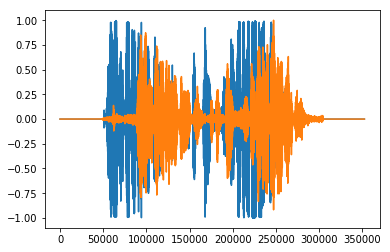

In [12]:
plt.plot(uZ)
plt.plot(dZ)

In [13]:
# Ahora hacemos las cuentas para estimar el filtro óptimo
LAGS = 20000
from scipy import linalg
from scipy import signal
def get_estimations(u,d):
    u_f = np.fft.fft(u)
    d_f = np.fft.fft(d)
    
    ##Estimo la autocorrelación
    print("Calculando R...")
    r = np.fft.ifft(u_f * u_f.conj()).real
    r = r[:len(u)//2]/len(u)
    ##Estimo la correlación cruzada
    print("Calculando P...")
    p = np.fft.ifft(u_f * d_f.conj()).real
    p = p[len(u)//2:]/len(u)
    p = np.flip(p)

    ##Energía de la señal deseada
    s2d = np.var(d)
    return r,p,s2d

rx, p, sigma2d = get_estimations(uZ,dZ)

rx=rx[0:LAGS]
p=p[0:LAGS]
R = toeplitz(rx)

# resuelve el sistema R wo = p
wo = np.dot(linalg.inv(R), p)

estimado = signal.filtfilt(wo,[1],u)

Calculando R...
Calculando P...


In [14]:
Audio(estimado,rate=fs)

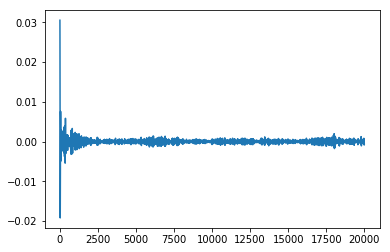

In [15]:
plt.plot(rx)

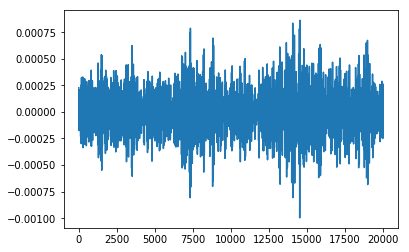

In [16]:
plt.plot(p)

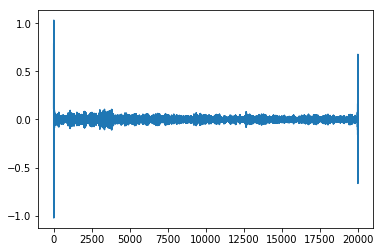

In [17]:
plt.plot(wo)


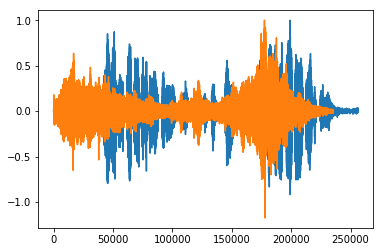

In [18]:
d = d/max(d)
estimado = estimado/max(estimado)
plt.plot(range(len(d)),d)
plt.plot(range(len(estimado)),estimado)
plt.show()

In [19]:
print("La varianza es : ",sigma2d)
Jmin = sigma2d - p.dot(wo)
epsilon = Jmin/sigma2d
print("Jmin es",Jmin)
print("Epsilon es",epsilon)

La varianza es :  0.01215988669799183
Jmin es 0.010435502025848142
Epsilon es 0.8581907286662084


In [0]:
from scipy.io.wavfile import write
write("/content/a.wav",fs,wo)